In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_val_score
from yellowbrick.classifier import DiscriminationThreshold
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, auc, roc_auc_score, classification_report, make_scorer, precision_recall_curve, roc_curve
from skopt.space import Real, Integer, Categorical
from skopt import BayesSearchCV
from tpot import TPOTClassifier
import optuna
data = load_breast_cancer()
X = pd.DataFrame(data['data'], columns=data['feature_names'])
y = pd.Series(data['target'])

In [2]:
clf = LogisticRegression(max_iter=10000)
clf.fit(X, y)

LogisticRegression(max_iter=10000)

### Classification Report and Confusion Matrix

Confusion matrix shows how each test values predicted classes compare to their actual classes.

Classification report represents the main classification metrics on a per class basis, that gives deeper intuition into a classifier's behaviour over global accuracy.

Basic terminology related to confusion matrix:
- True positive is when actual and predicted class is positive.

- False positive is when actual class is negative but predicted class is positive.

- True negative is when actual and predicted class is negative.

- False negative is when actual class is positive but predicted class is negative.

Note that positive and negative are generic names for the classes of a binary classification problem.

For multiclass problems, metrics are computed usually using a one-vs-rest approach.

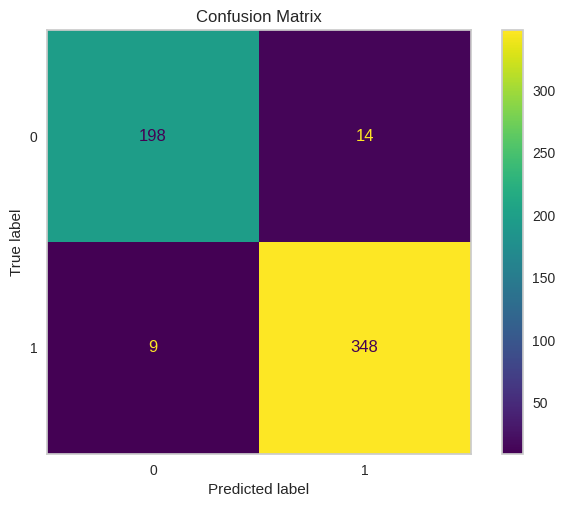

In [3]:
cmd = ConfusionMatrixDisplay.from_predictions(y, clf.predict(X))
cmd.ax_.set_title(f"Confusion Matrix")
plt.grid(False)
plt.show()

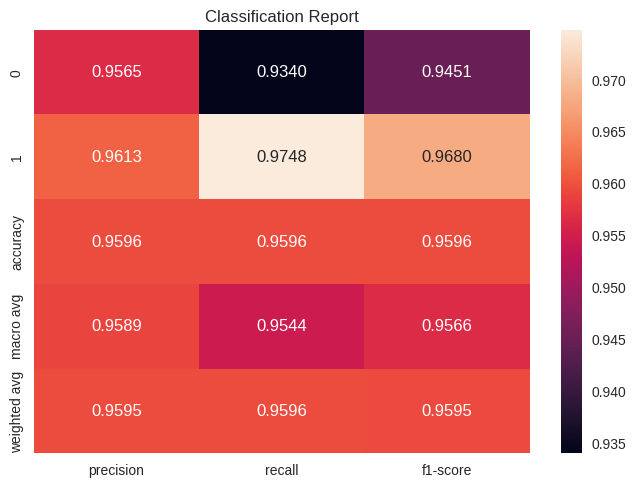

In [4]:
clf_report = classification_report(y,clf.predict(X),target_names=['0','1'],output_dict=True,digits=4)
fig = plt.figure()
sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, fmt=".4f")
plt.title("Classification Report")
plt.show()

## Evaluation Metrics for Classification

For classification problems, the following metrics can be used to evaluate model performance between train, validation and test set:
1. Accuracy
2. Precision
3. Recall/Sensitivity/True Positive rate
4. Specificity/True Negative rate
5. False positive rate/Type I error
6. False negative rate/Type II error
7. F1 score
8. F0.5 score
9. F2 score
10. Area under curve (AUC)
11. Cohen Kappa
12. Matthew's Correlation Coefficient
13. Log Loss

Note that metrics 1 to 7 can be obtained from the confusion matrix/classification report.

For multiclass classification, there are three different averaging techniques:

1. macro: Simple arithmetic mean of all metrics across classes, suitable for <b>imbalanced classes where all classes are equally important</b>
2. weighted: Average of binary metrics weighted by the number of samples of each class, suitable for <b>imbalanced classes where classes with higher number of samples are more important</b>
3. micro: Dividing the sum of the diagonal cells of the matrix by the sum of all the cells (Same as accuracy metric) , suitable for <b>balanced classes</b>

<b>Default probability threshold for classification problems is 0.5 for most Machine Learning algorithms.</b> This value can be adjusted if there is specific request for certain threshold value or if there is need for optimizing the best probability threshold that gives the best model performance.

### Accuracy

Accuracy measures how often a classifier correctly predicts a given outcome.

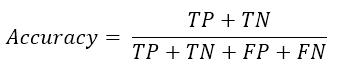

<b>Suitability to use for imbalanced classes: No</b>

### Precision

Precision measures the number of actual positives from total number of predicted positive outcome.

Precision is most suitable to use for focusing on reducing false positives.

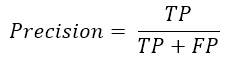

### Recall/Sensitivity/True positive rate

Recall measures the number of predicted positives from total number of actual positive outcome.

Recall is most suitable to use for focusing on reducing false negatives.

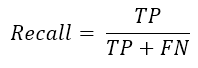

### Specificity/True negative rate

Specificity measures the number of predicted negatives from total number of actual negative outcome.

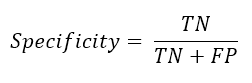

### False positive rate/Type I error

False positive rate/Type I error represents the proportion of false positives from total number of actual negative outcome.

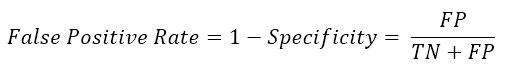

### False negative rate/Type II error

False negative rate/Type II error represents the proportion of false negatives from total number of actual positive outcome.

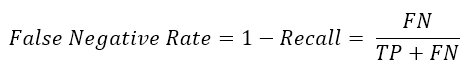

### F1 score

F1 score represents the harmonic mean between both precision and recall.

F1 score is most suitable to use when both precision and recall metrics have equal importances.

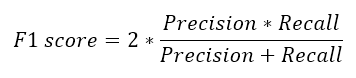

Note that F1 score is maximized when precision equals to recall.

In general, harmonic mean penalizes the most when either precision or recall scores is low, compared to using arithmetic mean or geometric mean.

<b>Suitability to use for imbalanced classes: Yes</b>

### F0.5 score

F0.5 score represents the weighted harmonic mean between both precision and recall, where more weights is given to precision.

F0.5 score is most suitable to use when false positives are more costly than false negatives and positive class is more important.

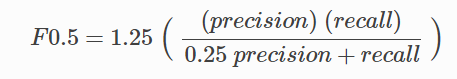

<b>Suitability to use for imbalanced classes: Yes</b>

### F2 score

F2 score represents the weighted harmonic mean between both precision and recall, where more weights is given to recall.

F2 score is most suitable to use when false negatives are more costly than false positives and positive class is more important.

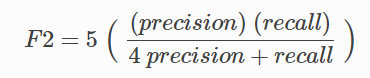

<b>Suitability to use for imbalanced classes: Yes</b>

### Area under curve (AUC)

Area under curve (AUC) measures the ability of a classifier to distinguish between classes.

On extreme cases:
1. AUC equals to 1 indicates that all positive and negative classes are distinguished correctly. (False positive and False negative equals to 0)

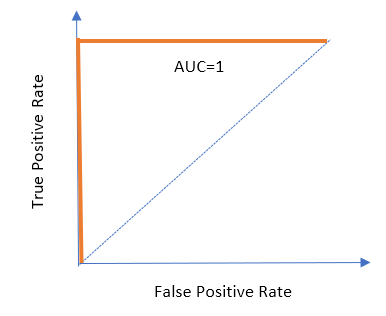

2. AUC equals to 0 indicates that all positive and negative classes are distinguished incorrectly. (True positive and true negative equals to 0)

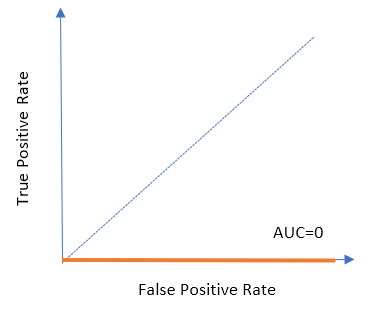

AUC score equals to 0.5 indicates classifier is random guessing with equal chance between true positive and false positive.

Note that this metric is only used with classifiers that can generate <b>class probabilities</b>.

<b> Suitability to use for imbalanced classes: No (For using ROC auc curve) / Yes (For using precision-recall curve)</b>

### Cohen Kappa Score

Cohen Kappa score measures inter-rater reliability for categorical items, which accounts possibility of agreement between actual and predicted values occuring by chance.

This metric can be used for multi-class classification problems.

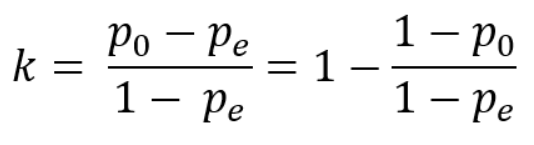

P_0 is the observed proportional agreement between actual and predicted values (sum of diagonal cells of confusion matrix divided by sum of non-diagonal cells).

P_e is the probability that both actual and predicted values are true by chance.

Cohen Kappa value interpretation:

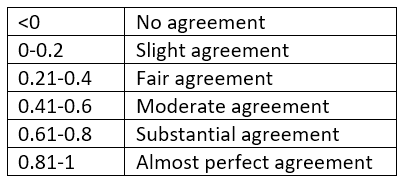

<b> Suitability to use for imbalanced classes: Yes </b>

### Matthew's Correlation Coefficient

Matthew's correlation coefficient (phi) measures the quality of binary and multiclass classifications. 

A score of 1.0 means a perfect classifier, while a value close to 0 means classifier is no better than random chance.

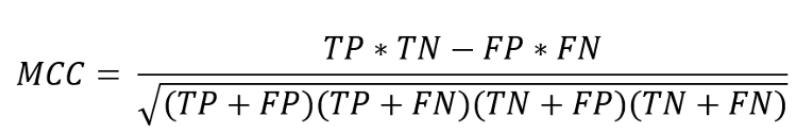

Note that coefficient values above 0.7 are generally considered as good scores.

Unlike F-score, Matthew's correlation coefficient considers the proportion of every class in the confusion matrix, which is more representative for performance of classifier on both positive and negative classes.

<b> Suitability to use for imbalanced classes: Yes </b>

### Log-Loss

Log-loss, also known as cross-entropy loss represents the value of a loss function.

Generally, the lower the value of log-loss, the better the performance of the classifier.

<b>Suitability to use for imbalanced classes: No</b>

## Optimum Threshold for Binary Classification Problems

By default, all ML classification algorithms assume the threshold used for selecting a class is 0.5. However, this default threshold is not always optimal for model performance.

Thus, determining optimal thresholds for a binary classification task depends on business context with the help of several tools available.

Two methods available for determining optimal thresholds of binary classification task:

1. ROC curves

2. Precision-recall curves

### ROC Curve

ROC curve represents the relationship between true positive rate (Recall) and false positive rate (Type I error) for different threshold values.

ROC curves should be used when target classes are balanced

Methods for optimum threshold using ROC curves:
- G-mean (Geometric mean between recall and specificity)
- Youden's J statistic (Difference between true positive rate and false positive rate)

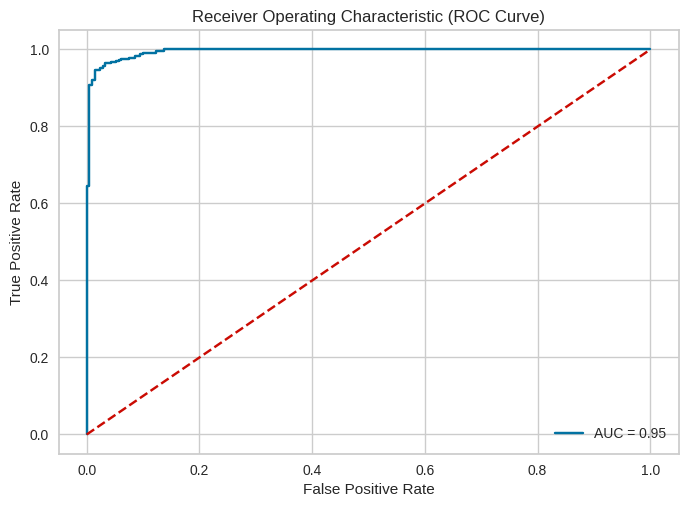

In [5]:
fpr, tpr, thresholds = roc_curve(y, clf.predict_proba(X)[:,1])
plt.title('Receiver Operating Characteristic (ROC Curve)')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_score(y, clf.predict(X)))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [6]:
# Optimal threshold determined based on Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
print(f"Optimal threshold: {thresholds[optimal_idx]}")

Optimal threshold: 0.7793179277066189


In [7]:
# Optimal threshold determined based on G-mean
optimal_idx = np.argmax(np.sqrt(tpr * (1 - fpr)))
print(f"Optimal threshold: {thresholds[optimal_idx]}")

Optimal threshold: 0.7793179277066189


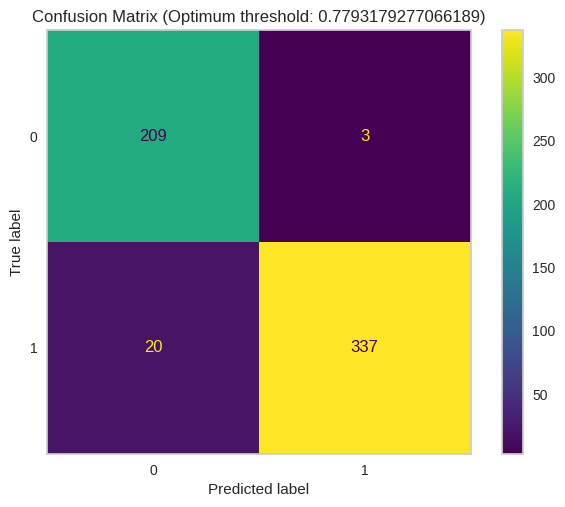

In [8]:
clf = LogisticRegression(max_iter=10000)
clf.fit(X, y)
y_pred_proba = clf.predict_proba(X)[:,1]
y_pred = np.where(y_pred_proba>thresholds[optimal_idx],1,0)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title(f"Confusion Matrix (Optimum threshold: {thresholds[optimal_idx]})")
plt.grid(False)
plt.show()

### Precision-recall curve

Precision recall curve represents the relationship between precision and recall for different threshold values.

Precision-recall curve should be used when target classes are imbalanced.

Methods for optimum threshold using precision-recall curves:
- F1 score

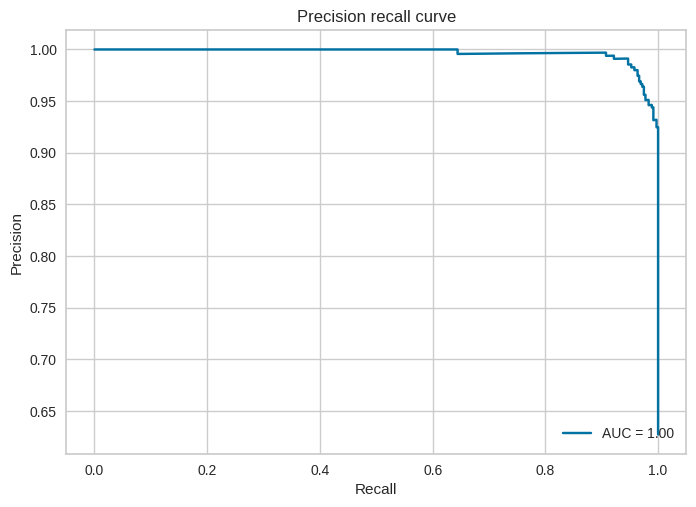

In [9]:
precisions, recalls, thresholds = precision_recall_curve(y, clf.predict_proba(X)[:,1])
plt.title('Precision recall curve')
plt.plot(recalls, precisions, 'b', label = 'AUC = %0.2f' % auc(recalls, precisions))
plt.legend(loc = 'lower right')
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

In [10]:
fscore = 2 * (precisions*recalls)/(precisions+recalls)
index = np.argmax(fscore)
print(f"Optimal threshold: {thresholds[index]}")

Optimal threshold: 0.654791908174566


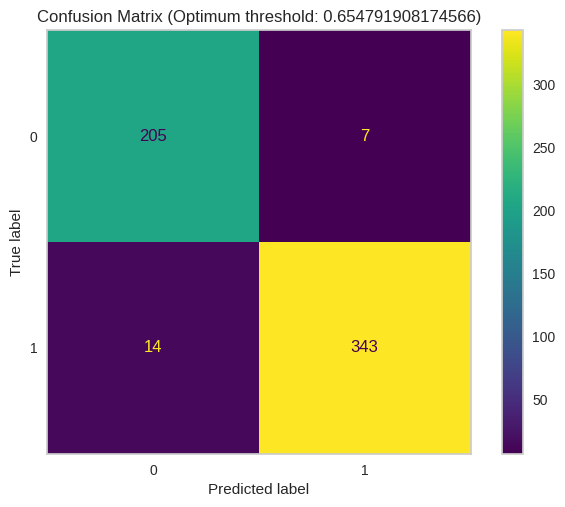

In [11]:
# Confusion matrix heatmap for optimum threshold using f score
clf = LogisticRegression(max_iter=10000)
clf.fit(X, y)
y_pred_proba = clf.predict_proba(X)[:,1]
y_pred = np.where(y_pred_proba>thresholds[index],1,0)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title(f"Confusion Matrix (Optimum threshold: {thresholds[index]})")
plt.grid(False)
plt.show()

### Discrimination-Threshold Curve (Binary Classification only)

Discrimination threshold is probability or score at which positive class is chosen over negative class. Generally, this is set to 50% but threshold can be adjusted to increase or decrease sensitivity to false positives or to other application factors.

In addition, an additional metric known as queue rate is included in this visualization plot.

Queue rate describes percentage of instances that must be reviewed.

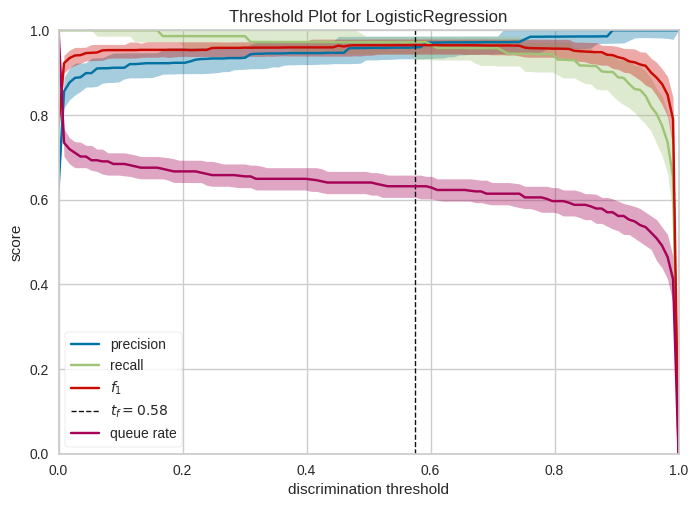

In [12]:
clf = LogisticRegression(max_iter=10000)
visualizer = DiscriminationThreshold(clf, random_state=120, cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=120))
visualizer.fit(X,y)
visualizer.show()
plt.show()

## Bagging vs Boosting (Ensemble Techniques)

In machine learning, ensemble techniques can be used to improve performance of weak base learners.

Two main ensemble methods available are:
1. <b>Bagging</b>: Creates several subsets of data from training sample chosen randomly with replacement and trains on individual weak learners parallelly (same or different types) to reduce model overfitting.
- For regression task, <b>average of predictions</b> from all learners are used.
- For classification task, <b>majority voting</b> from all learners are used.

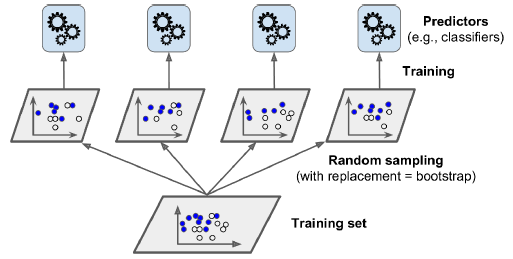

2. <b>Boosting</b>: Individual learners (same types) are learned sequentially with early learners fitting simple models to the data and then analysing data for errors for further model improvement.

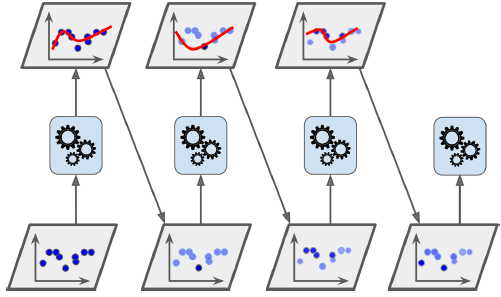

<b>Difference between Bagging and Boosting</b>:

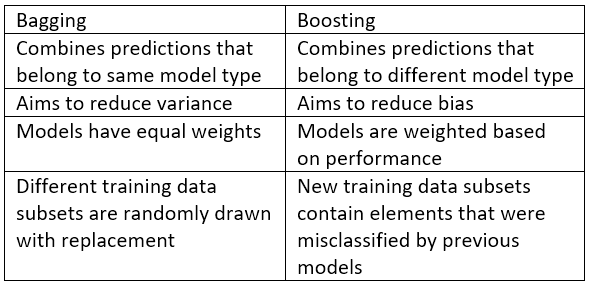

## Hyperparameter Tuning Methods

All machine learning models have hyperparameters, which are model configuration arguments specified by the developer to guide the model learning process for a specific dataset.

Hyperparameter tuning is essential for maximizing model performance.

The following sections below shows the types of hyperparameter tuning techniques available:

1. Randomized Search CV
2. Grid Search CV
3. Bayesian Optimization
4. Genetics Algorithm
5. Optuna

## Randomized Search CV

Randomized search CV involves defining a search space as a bounded domain of hyperparameter values and randomly sample points within that domain.

Randomized search CV is mostly suitable for initial search of hyperparameter values that provides reasonably good model performance within a very large search space.

Fitting 5 folds for each of 10 candidates, totalling 50 fits


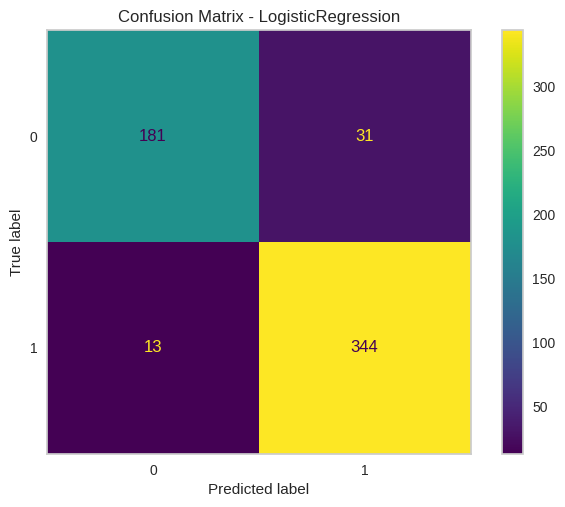

Best params identified: {'C': 0.9, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [13]:
clf = LogisticRegression(max_iter=10000, solver='saga')
param_grid = {'penalty': ['l1','l2'], 
              'C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]}
search = RandomizedSearchCV(clf,param_grid,cv=5,n_jobs=3,verbose=1,scoring=make_scorer(f1_score, average='macro'))
search.fit(X, y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - LogisticRegression")
plt.grid(False)
plt.show()
print('Best params identified:',search.best_estimator_.get_params())

## Grid Search CV

Grid search CV involves defining a search space as a bounded domain of hyperparameter values and evaluate model performance for all possible combinations of values within the search space.

Grid search CV is preferable for more concise search spaces, as execution time increases significantly for very large search spaces.

Fitting 5 folds for each of 40 candidates, totalling 200 fits


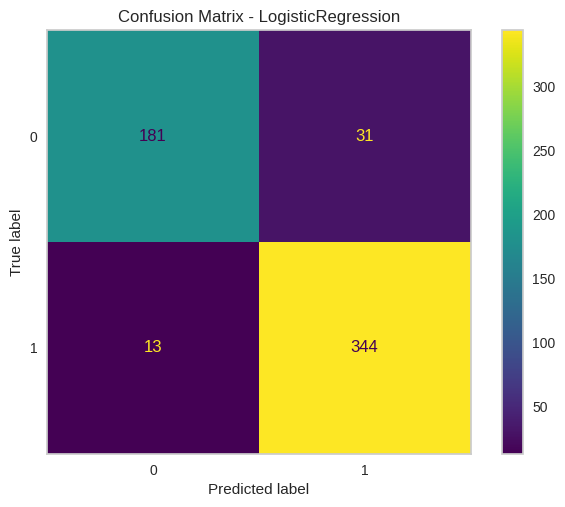

Best params identified: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [14]:
clf = LogisticRegression(max_iter=10000, solver='saga')
param_grid = {'penalty': ['l1','l2'], 
              'C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]}
search = GridSearchCV(clf,param_grid,cv=5,n_jobs=3,verbose=1,scoring=make_scorer(f1_score, average='macro'))
search.fit(X, y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - LogisticRegression")
plt.grid(False)
plt.show()
print('Best params identified:',search.best_estimator_.get_params())

## Bayesian Optimization

For hyperparameter tuning, bayesian optimization uses probability to find the minimum value of an objective function.

This method usually provides better model performance than random search and grid search, while reducing optimization time.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


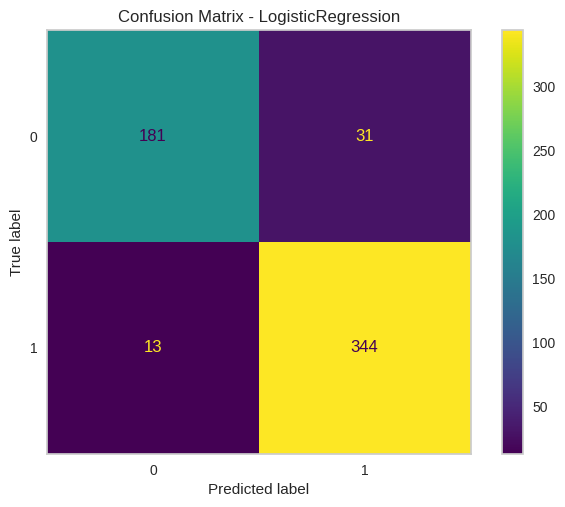

Best params identified: {'C': 1.02631562482178, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 10000, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': None, 'solver': 'saga', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


In [15]:
clf = LogisticRegression(max_iter=10000, solver='saga')
search_space = dict()
search_space['C'] = Real(0.0001,2,'log-uniform')
search_space['penalty'] = Categorical(['l1','l2'])
search = BayesSearchCV(estimator=clf, search_spaces=search_space, cv=5, n_iter=10, scoring= make_scorer(f1_score, average='macro'),refit=True, n_jobs=3, verbose=3)
search.fit(X,y)
y_pred = search.best_estimator_.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - LogisticRegression")
plt.grid(False)
plt.show()
print('Best params identified:',search.best_estimator_.get_params())

## Genetics Algorithm

Genetics algorithm attempts to apply natural selection mechanisms to determine best machine learning models to use.

By having a population of N machine learning models with different hyperparameters, scoring of each model is computed and a proportion of models are kept for generating N offsprings having similar hyperparameters to the best ones identified.

The cycle repeats for a defined number of generations, such that only the best models will remain at the end of the algorithm.

Optimization Progress:   0%|          | 0/600 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.9114073737876003

Generation 2 - Current best internal CV score: 0.9114073737876003

Generation 3 - Current best internal CV score: 0.9114073737876003

Generation 4 - Current best internal CV score: 0.9114073737876003

Generation 5 - Current best internal CV score: 0.9114073737876003

Best pipeline: LogisticRegression(CombineDFs(input_matrix, input_matrix), C=1.3, max_iter=1000, penalty=l1, solver=saga)


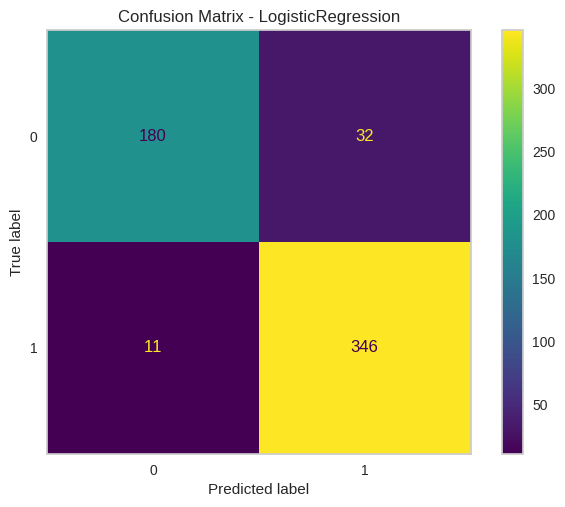

In [18]:
param_grid = {'penalty': ['l1','l2'], 
              'C': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2],
             'max_iter': [1000], 'solver':['saga']}
search = TPOTClassifier(generations= 5, verbosity= 2, config_dict={'sklearn.linear_model.LogisticRegression': param_grid}, 
                        cv = 5, scoring = make_scorer(f1_score, average='macro'))
search.fit(X,y)
y_pred = search.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - LogisticRegression")
plt.grid(False)
plt.show()

## Optuna

Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning.

Unlike other hyperparameter optimization frameworks, Optuna sets itself apart from others with the following unique features:

1. Efficient optimization algorithms that prunes unpromising trials

2. Easy parallelization for optimizing multiple models simultaneously.

Terminologies used in Optuna:
- <b>Study</b>: optimization based on an objective function
- <b>Trial</b>: a single execution of the objective function

In [19]:
def objective(trial):
    penalty = trial.suggest_categorical('penalty', ['l1','l2'])
    C = trial.suggest_float('C', 0.0001, 2, log=True)
    clf = LogisticRegression(max_iter=10000, solver='saga', penalty=penalty, C=C)
    return cross_val_score(clf,X,y, n_jobs=1, cv=5, scoring = make_scorer(f1_score, average='macro')).mean()

[I 2022-11-11 10:05:05,537] A new study created in memory with name: no-name-aaf018d1-4339-4be4-9d70-3814710d94a8
[I 2022-11-11 10:05:09,960] Trial 0 finished with value: 0.915575632474068 and parameters: {'penalty': 'l1', 'C': 0.048147858387024935}. Best is trial 0 with value: 0.915575632474068.
[I 2022-11-11 10:05:14,926] Trial 1 finished with value: 0.915575632474068 and parameters: {'penalty': 'l1', 'C': 1.2294144428642102}. Best is trial 0 with value: 0.915575632474068.
[I 2022-11-11 10:05:19,250] Trial 2 finished with value: 0.9156564488765417 and parameters: {'penalty': 'l1', 'C': 0.034857585743317814}. Best is trial 2 with value: 0.9156564488765417.
[I 2022-11-11 10:05:20,836] Trial 3 finished with value: 0.9130103229550585 and parameters: {'penalty': 'l2', 'C': 0.00019304295927350597}. Best is trial 2 with value: 0.9156564488765417.
[I 2022-11-11 10:05:23,894] Trial 4 finished with value: 0.915575632474068 and parameters: {'penalty': 'l2', 'C': 0.00323499323459869}. Best is tr

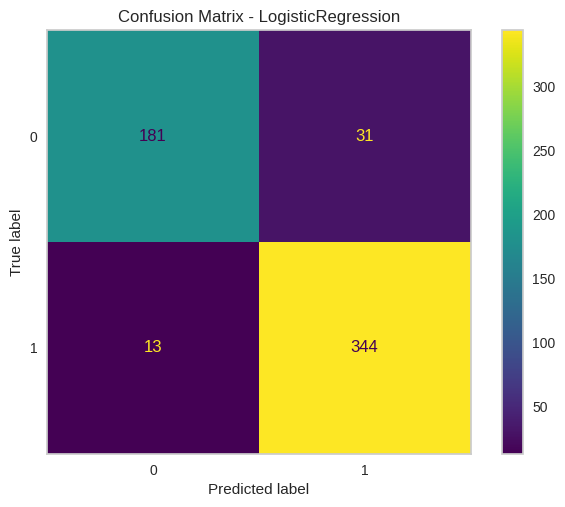

Best hyperparameters: {'penalty': 'l1', 'C': 0.04020495699370014}


In [20]:
sampler = optuna.samplers.TPESampler(multivariate=True, seed=120)
study = optuna.create_study(direction='maximize',  sampler=sampler)
study.optimize(objective, n_trials=20)
trial = study.best_trial
clf = LogisticRegression(max_iter=10000, solver='saga', penalty=trial.params['penalty'], C=trial.params['C'])
clf.fit(X,y)
y_pred = clf.predict(X)
cmd = ConfusionMatrixDisplay.from_predictions(y, y_pred)
cmd.ax_.set_title("Confusion Matrix - LogisticRegression")
plt.grid(False)
plt.show()
print("Best hyperparameters: {}".format(trial.params))